## Topic modeling

The books are downloaded in a directory called "Plaintexts" that is on the same directory as this notebook for simplicity.

We use three ebook texts with different topics from Gutenburg:
1. [Adrift in New York (children fiction)](http://www.gutenberg.org/cache/epub/18581/pg18581.txt)
2. [Beethoven (music)](http://www.gutenberg.org/cache/epub/15141/pg15141.txt)
3. [Sandwiches (cook)](http://www.gutenberg.org/cache/epub/29329/pg29329.txt)

In [1]:
import glob, os
import codecs
from pprint import pprint

# directory with the downloaded texts
texts_dir = "Plaintexts"
# get all the .txt files in "Plaintexts" directory in list
textfiles = glob.glob(os.path.join(texts_dir, "*.txt"), recursive=False)
print("Files found:")
pprint(textfiles)

def read_txt(filename):
    """Function to read the text files and return text"""
    with codecs.open(filename,'r','utf-8') as f:
        text = f.read()
        return text

# import the textfiles into a list
raw_texts = []
for textfile in textfiles:
    raw_texts.append(read_txt(textfile))
print("\nItems in list:", len(raw_texts))

Files found:
['Plaintexts/Sandwiches.txt',
 'Plaintexts/Beethoven.txt',
 'Plaintexts/Adrift in New York.txt']

Items in list: 3


### Preprocessing

We iterate through the three text files and remove stopwords, punctuation and lemmatize.

In [2]:
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string

punctuation = set(string.punctuation) # retrieve punctuation set
use_stopwords = stopwords.words('english')
lemmatize = WordNetLemmatizer()

clean_texts = []
for text in raw_texts:
    tok = " ".join(word_tokenize(text))  # tokenize
   
    #remove punctuation
    re_punc = "".join(i for i in tok if i not in punctuation)
    
    #remove stopwords
    re_sw = " ".join([i for i in re_punc.lower().split() if i not in use_stopwords])
    
    #lemmatization
    le = " ".join(lemmatize.lemmatize(i) for i in re_sw.split())
    clean_texts.append(le)

### Converting the text into a matrix of tokens

In [3]:
from sklearn.feature_extraction.text import CountVectorizer  

# only consider top 1000 vocabulary ordered by 
# term frequency across the entire text corpus
n_features = 1000

#vectorize text
tf_vectorizer = CountVectorizer(min_df = 2,
                                strip_accents = 'unicode',
                                max_features=n_features,
                                stop_words='english')

# learn vocabulary and return term-document matrix
tf = tf_vectorizer.fit_transform(clean_texts)
pprint(tf_vectorizer, indent=2)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=1000, min_df=2,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents='unicode', token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)


### LDA topic modeling

A brief example to explain LDA topic modeling.

Suppose you have the following set of sentences:

* I like to eat broccoli and bananas.
* I ate a banana and spinach smoothie for breakfast.
* Chinchillas and kittens are cute.
* My sister adopted a kitten yesterday.
* Look at this cute hamster munching on a piece of broccoli.

What is Latent Dirichlet Allocation? It’s a way of automatically discovering **topics** that these sentences contain. For example, given these sentences and asked for 2 topics, LDA might produce something like

* **Sentences 1 and 2:** 100% Topic A
* **Sentences 3 and 4:** 100% Topic B
* **Sentence 5:** 60% Topic A, 40% Topic B
* **Topic A:** 30% broccoli, 15% bananas, 10% breakfast, 10% munching, … (at which point, you could interpret topic A to be about food)
* **Topic B:** 20% chinchillas, 20% kittens, 20% cute, 15% hamster, … (at which point, you could interpret topic B to be about cute animals)

Reference: http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation/

In [4]:
from sklearn.decomposition import LatentDirichletAllocation

# set the topic counts
n_topic = 3

lda = LatentDirichletAllocation(n_components = n_topic, 
                                learning_method='online',
                                max_iter=50,
                                random_state=0)
lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=50, mean_change_tol=0.001,
             n_components=3, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

### Showing topics

Using the [LDA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html) generated above, we can derive the top words

In [5]:
def print_top_words(model, feature_names, n_top_words):
    """print top terms in each topic"""
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

# set the top n words in each topic
n_top_words=20
        
# ngrams featured in the text
tf_feature_names = tf_vectorizer.get_feature_names()

print_top_words(lda, tf_feature_names, n_top_words)

Topic #0:
work time music year life man great master project friend art letter new good mind form way world thought best
Topic #1:
nt said mr know boy think man uncle yes like miss asked young work say time come make good sir
Topic #2:
bread cut add half project work salt make gutenbergtm chicken spread buttered cover press cold white book meat fish fine


### From the three topics, we can deduce that:
- Topic 0: Music related
- Topic 1: Children related
- Topic 2: Food related

### Visualizing topic models
We now have the data to visualize the topic models

#### Visualize topic distribution
We first get the probability of topic distrubition in the three texts.

In [6]:
# topic_distribution is a distribution of the topics in each text
topic_distribution = lda.transform(tf)

pprint(topic_distribution, indent=2) # not normalized (sum of each row is not 1)

array([[  7.62866950e-05,   7.44415098e-05,   9.99849272e-01],
       [  9.99643034e-01,   3.29740441e-04,   2.72253200e-05],
       [  2.78363581e-04,   9.99694149e-01,   2.74872964e-05]])


#### Next we will try to visualize the topic distribution in a heatmap.

<Figure size 432x288 with 0 Axes>

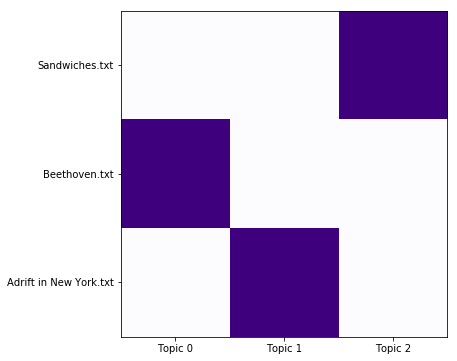

In [7]:
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

flight_matrix = topic_distribution 

# set labels of Y axis as filenames
yLabel = [os.path.basename(textfile) for textfile in textfiles]

# set labels of X axis as topic index
xLabel = list(range(n_topic))

# add "Topic " to each element (1,2,3) in xLabel
for i in range(len(xLabel)):
    xLabel[i] = "Topic {}".format(xLabel[i])

fig = plt.figure()
fig, ax = plt.subplots(1,1, figsize=(6,6))

ax.set_xticks(np.arange(len(xLabel)))
ax.set_yticks(np.arange(len(yLabel)))

ax.set_xticklabels(xLabel)
ax.set_yticklabels(yLabel)

heatplot = ax.imshow(flight_matrix, cmap='Purples')

### As we discovered above:
    
* Topic 0: Music related
* Topic 1: Children related  
* Topic 2: Food related

The distribution figure shows that the topics generated are correspondent with the content of the three texts.

### Interactive visualization using pyLDAvis

[pyLDAvis](https://github.com/bmabey/pyLDAvis) is a Python library for interactive topic model visualization. Port of the R LDAvis package. You can install it via pip as shown below:

In [8]:
!pip install pyLDAvis>==2.1.1

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [9]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)

/home/anthony/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      43.144846        1       1 -0.070523 -0.100311
1      42.326458        1       2 -0.135995  0.081137
2      14.528696        1       3  0.206519  0.019175, topic_info=     Category        Freq         Term       Total  loglift  logprob
term                                                                
617   Default  544.000000           nt  544.000000  30.0000  30.0000
150   Default  195.000000        bread  195.000000  29.0000  29.0000
790   Default  500.000000         said  500.000000  28.0000  28.0000
234   Default  129.000000          cut  129.000000  27.0000  27.0000
72    Default  110.000000          add  110.000000  26.0000  26.0000
431   Default  136.000000         half  136.000000  25.0000  25.0000
597   Default  371.000000           mr  371.000000  24.0000  24.0000
598   Default  213.000000        music  213.000000  23.0000  23.0000
791   Default   74.000000         salt   74.000000  22.0000  22.0000
718   Default  265.000000      project  265.000000  21.0000  21.0000
996   Default  152.000000          yes  152.000000  20.0000  20.0000
986   Default  600.000000         work  600.000000  19.0000  19.0000
916   Default  166.000000        think  166.000000  18.0000  18.0000
586   Default  146.000000         miss  146.000000  17.0000  17.0000
181   Default   54.000000      chicken   54.000000  16.0000  16.0000
155   Default   51.000000     buttered   51.000000  15.0000  15.0000
855   Default   53.000000       spread   53.000000  14.0000  14.0000
149   Default  200.000000          boy  200.000000  13.0000  13.0000
232   Default   50.000000        cover   50.000000  12.0000  12.0000
566   Default  139.000000       master  139.000000  11.0000  11.0000
942   Default  170.000000        uncle  170.000000  10.0000  10.0000
705   Default   52.000000        press   52.000000   9.0000   9.0000
193   Default   57.000000         cold   57.000000   8.0000   8.0000
112   Default  150.000000        asked  150.000000   7.0000   7.0000
975   Default   50.000000        white   50.000000   6.0000   6.0000
428   Default  162.000000  gutenbergtm  162.000000   5.0000   5.0000
558   Default  204.000000         make  204.000000   4.0000   4.0000
502   Default  208.000000         know  208.000000   3.0000   3.0000
573   Default   40.000000         meat   40.000000   2.0000   2.0000
146   Default   57.000000         book   57.000000   1.0000   1.0000
...       ...         ...          ...         ...      ...      ...
634    Topic3   31.124788        olive   33.782196   1.8471  -5.0602
766    Topic3   28.323160       remove   30.974490   1.8396  -5.1545
705    Topic3   47.931473        press   52.559311   1.8369  -4.6285
169    Topic3   17.120531       center   18.785570   1.8362  -5.6579
866    Topic3   23.655130         stir   26.304633   1.8229  -5.3346
505    Topic3   13.386917           la   15.044632   1.8123  -5.9039
145    Topic3   13.390032      boiling   15.048198   1.8123  -5.9037
697    Topic3   29.252662        pound   32.888747   1.8119  -5.1223
857    Topic3   20.850312       square   23.497646   1.8095  -5.4609
167    Topic3   12.452858       caviar   14.110387   1.8041  -5.9763
968    Topic3   32.049277        water   36.667606   1.7944  -5.0309
927    Topic3   18.054839       tongue   20.698190   1.7924  -5.6048
975    Topic3   44.194804        white   50.772138   1.7903  -4.7096
905    Topic3   17.121753          tea   19.759459   1.7858  -5.6579
839    Topic3   16.189572       smooth   18.826079   1.7782  -5.7139
528    Topic3   20.856396        level   24.478129   1.7689  -5.4606
431    Topic3  101.141319         half  136.104598   1.6321  -3.8817
193    Topic3   45.127060         cold   57.569428   1.6855  -4.6887
814    Topic3   27.394557        serve   36.883833   1.6316  -5.1879
146    Topic3   38.598101         book   57.863069   1.5242  -4.8450
168    Topic3   27.391035     

### Understanding the visualizations
- The size of the circle represents the documents in each topic
- The bars in the left part show the most frequent keywords in each topic
- The distance among the circles shows the similarity of different topics
- Set λ = 1, the words with high frequency are more relevant to the topic,
- Set λ = 0, words more exclusive are more relavent to the topic.

### About pyLDAvis

[pyLDAvis](http://pyldavis.readthedocs.io/en/latest/modules/API.html) is designed to help users interpret the topics in a topic model that has been fit to a corpus of text data. The
package extracts information from a fitted LDA topic model to inform an interactive web-based visualization

It answers three questions:
 1. What is the meaning of each topic?
 2. How prevalent is each topic?
 3. How do the topics relate to each other?
